<a href="https://colab.research.google.com/github/SAURAV9182000/Skin-Cancer-Fairness/blob/main/EfficientNetModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Installing Requirements

## Importing Required Libraries

In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import timm
import torch.optim as optim
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

## Load the csv file and Image data

In [35]:
def set_seed(seed):
    """Sets the random seed for reproducibility across different libraries."""
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed) # for multi-GPU
    np.random.seed(seed)
    # These two lines are for deterministic behavior on CUDA, which can sometimes
    # have a small performance impact but helps reproducibility.
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    print(f"Seed set to {seed}")

In [36]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [47]:
df = pd.read_csv('/DermaMNISTDataset.csv')
npz = np.load('/DermaMNIST_Corrected_224.npz')

In [48]:
def create_age_bins(df):
    """Create age bins: 50-60, 60-65, 65-80"""
    df['age_group'] = pd.cut(df['age'],
                            bins=[49, 60, 65, 80],
                            labels=['50-60', '60-65', '65-80'],
                            include_lowest=True)
    return df

df = create_age_bins(df)

In [49]:
label_encoder = LabelEncoder()
df['dx_enc'] = label_encoder.fit_transform(df['dx'])

print("Dataset Overview:")
print(f"Total samples: {len(df)}")
print(f"Classes: {label_encoder.classes_}")
print(f"Gender distribution: {df['sex'].value_counts()}")
print(f"Age group distribution: {df['age_group'].value_counts()}")

Dataset Overview:
Total samples: 10015
Classes: ['akiec' 'bcc' 'bkl' 'df' 'mel' 'nv' 'vasc']
Gender distribution: sex
male       5406
female     4552
unknown      57
Name: count, dtype: int64
Age group distribution: age_group
50-60    2999
65-80    1778
60-65     731
Name: count, dtype: int64


In [50]:
#Split by gender and age for each class
def analyze_demographic_distribution(df):
    """Analyze distribution across demographics"""
    print("\n=== Demographic Distribution Analysis ===")

    # Gender distribution per class
    gender_class_dist = pd.crosstab(df['dx'], df['sex'])
    print("\nGender distribution per class:")
    print(gender_class_dist)

    # Age group distribution per class
    age_class_dist = pd.crosstab(df['dx'], df['age_group'])
    print("\nAge group distribution per class:")
    print(age_class_dist)

    # Combined analysis
    combined_dist = df.groupby(['dx', 'sex', 'age_group']).size().unstack(fill_value=0)
    print("\nCombined demographic distribution:")
    print(combined_dist)

    return gender_class_dist, age_class_dist, combined_dist

gender_dist, age_dist, combined_dist = analyze_demographic_distribution(df)



=== Demographic Distribution Analysis ===

Gender distribution per class:
sex    female  male  unknown
dx                          
akiec     106   221        0
bcc       197   317        0
bkl       463   626       10
df         52    63        0
mel       424   689        0
nv       3237  3421       47
vasc       73    69        0

Age group distribution per class:
age_group  50-60  60-65  65-80
dx                            
akiec        104     38    140
bcc           87     79    234
bkl          313    108    434
df            40     18     16
mel          344    133    342
nv          2068    351    576
vasc          43      4     36

Combined demographic distribution:
age_group      50-60  60-65  65-80
dx    sex                         
akiec female      38     14     46
      male        66     24     94
      unknown      0      0      0
bcc   female      37     39     71
      male        50     40    163
      unknown      0      0      0
bkl   female     159     45    162

In [51]:
class DermaDataset(Dataset):
    def __init__(self, images, labels, demographics=None):
        self.images = images.astype(np.float32) / 255.0
        self.labels = labels
        self.demographics = demographics

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img = self.images[idx]
        img = np.transpose(img, (2, 0, 1))
        label = self.labels[idx]

        if self.demographics is not None:
            return torch.tensor(img, dtype=torch.float32), torch.tensor(label, dtype=torch.long), self.demographics.iloc[idx]
        else:
            return torch.tensor(img, dtype=torch.float32), torch.tensor(label, dtype=torch.long)


In [53]:
# Prepare datasets with demographic information
train_idx = df[df['split'] == 'train'].index
val_idx = df[df['split'] == 'val'].index
test_idx = df[df['split'] == 'test'].index

train_labels = df.loc[train_idx, 'dx_enc'].to_numpy()
val_labels = df.loc[val_idx, 'dx_enc'].to_numpy()
test_labels = df.loc[test_idx, 'dx_enc'].to_numpy()

train_demographics = df.loc[train_idx, ['sex', 'age_group']].reset_index(drop=True)
val_demographics = df.loc[val_idx, ['sex', 'age_group']].reset_index(drop=True)
test_demographics = df.loc[test_idx, ['sex', 'age_group']].reset_index(drop=True)

In [70]:

# 3. Training function with multiple model architectures
def create_model(model_name, num_classes=7):
    """Create different model architectures"""
    if model_name == 'efficientnet':
        model = timm.create_model('efficientnet_b1', pretrained=True)
        model.classifier = nn.Linear(model.classifier.in_features, num_classes)
    elif model_name == 'resnet':
        model = timm.create_model('resnet50', pretrained=True)
        model.fc = nn.Linear(model.fc.in_features, num_classes)
    elif model_name == 'vgg':
        model = timm.create_model('vgg16', pretrained=True)
        model.classifier[-1] = nn.Linear(model.classifier[-1].in_features, num_classes)
    else:
        raise ValueError(f"Unsupported model: {model_name}")

    return model

def train_model(model, train_loader, val_loader, device, num_epochs=10, lr=1e-4):
    """Train model and return metrics"""
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    train_losses = []
    val_losses = []
    val_accuracies = []

    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")

        # Training
        model.train()
        running_loss = 0.0
        for batch_data in train_loader:
            # Handle datasets with or without demographics
            if len(batch_data) == 3:
                images, labels, _ = batch_data
            else:
                images, labels = batch_data

            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()

            outputs = model(images)
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            running_loss += loss.item() * images.size(0)

        train_loss = running_loss / len(train_loader.dataset)

        # Validation
        model.eval()
        val_loss = 0.0
        correct = 0

        with torch.no_grad():
            for batch_data in val_loader:
                 # Handle datasets with or without demographics
                if len(batch_data) == 3:
                    images, labels, _ = batch_data
                else:
                    images, labels = batch_data

                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * images.size(0)
                preds = outputs.argmax(1)
                correct += (preds == labels).sum().item()

        val_loss /= len(val_loader.dataset)
        val_acc = correct / len(val_loader.dataset)

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)

        print(f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")

    return model, train_losses, val_losses, val_accuracies

In [80]:
# Fixing the indentation error by ensuring consistent indentation throughout the function
def evaluate_model_demographics(model, test_loader, test_demographics, device, label_encoder):
    """Evaluate model performance across demographic groups"""
    model.eval()
    all_preds = []
    all_labels = []
    all_demographics = []

    with torch.no_grad():
        batch_idx = 0
        for batch_data in test_loader:
            if len(batch_data) == 3:
                images, labels, _ = batch_data
            else:
                images, labels = batch_data

            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            preds = outputs.argmax(1)

            batch_size = len(labels)
            start_idx = batch_idx * test_loader.batch_size
            end_idx = start_idx + batch_size

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_demographics.extend(test_demographics.iloc[start_idx:end_idx].values.tolist())

            batch_idx += 1


In [75]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = timm.create_model('efficientnet_b1', pretrained=True)
model.classifier = nn.Linear(model.classifier.in_features, 7)
model = model.to(device)

model.safetensors:   0%|          | 0.00/31.5M [00:00<?, ?B/s]

In [86]:
 results = {}
 df

,lesion_id,image_id,dx,dx_type,age,sex,localization,dataset,split,age_group,dx_enc
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,vidir_modern,train,65-80,2
1,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,vidir_modern,train,65-80,2
2,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,vidir_modern,train,65-80,2
3,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,vidir_modern,train,65-80,2
4,HAM_0001466,ISIC_0027850,bkl,histo,75.0,male,ear,vidir_modern,train,65-80,2
...,...,...,...,...,...,...,...,...,...,...,...
10010,HAM_0007199,ISIC_0030344,akiec,histo,55.0,female,face,rosendahl,test,50-60,0
10011,HAM_0003934,ISIC_0027767,akiec,histo,85.0,male,back,rosendahl,test,NaN,0
10012,HAM_0006587,ISIC_0025780,akiec,histo,70.0,male,face,rosendahl,test,65-80,0
10013,HAM_0006902,ISIC_0031506,akiec,histo,70.0,male,hand,rosendahl,test,65-80,0


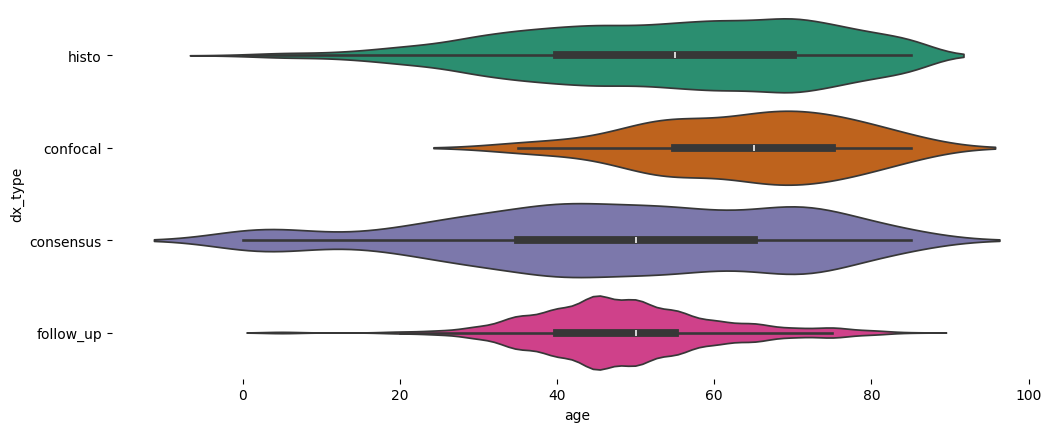

In [88]:
# @title dx_type vs age

from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(df['dx_type'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(df, x='age', y='dx_type', inner='box', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

In [96]:
# Fixing the indentation error by ensuring consistent indentation throughout the function
def evaluate_model_demographics(model, test_loader, test_demographics, device, label_encoder):
    """Evaluate model performance across demographic groups"""
    model.eval()
    all_preds = []
    all_labels = []
    all_demographics_list = [] # Use a different name to avoid conflict before converting to array

    with torch.no_grad():
        # Keep track of the index in the original test_demographics DataFrame
        demographics_start_idx = 0
        for batch_data in test_loader:
            if len(batch_data) == 3:
                images, labels, _ = batch_data # We extract images and labels
            else:
                images, labels = batch_data

            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            preds = outputs.argmax(1)

            batch_size = len(labels)

            # Append batch results to lists
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

            # Extract and append demographic data for the current batch
            # We use the demographics_start_idx and batch_size to slice the original DataFrame
            demographics_end_idx = demographics_start_idx + batch_size
            all_demographics_list.extend(test_demographics.iloc[demographics_start_idx:demographics_end_idx].values.tolist())

            # Update the index for the next batch
            demographics_start_idx = demographics_end_idx

    # The code that was in the separate cell ipython-input-95-2518939231 is now inside the function
    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)
    all_demographics = np.array(all_demographics_list) # Convert the list to numpy array

    print("\n=== Overall Test Set Evaluation ===")
    overall_accuracy = accuracy_score(all_labels, all_preds)
    print(f"Overall Accuracy: {overall_accuracy:.4f}")

    print("\n=== Classification Report ===")
    class_names = label_encoder.classes_
    print(classification_report(all_labels, all_preds, target_names=class_names))

    print("\n=== Confusion Matrix ===")
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()

    print("\n=== Demographic Specific Evaluation ===")
    demographics_df = pd.DataFrame(all_demographics, columns=['sex', 'age_group'])
    evaluation_df = pd.DataFrame({'true_label': all_labels, 'predicted_label': all_preds})
    evaluation_df = pd.concat([evaluation_df, demographics_df], axis=1)

    def evaluate_group(group_df, group_name):
        if not group_df.empty:
            group_accuracy = accuracy_score(group_df['true_label'], group_df['predicted_label'])
            print(f"\n--- {group_name} ---")
            print(f"Accuracy: {group_accuracy:.4f}")
            # print(classification_report(group_df['true_label'], group_df['predicted_label'], target_names=class_names, zero_division=0))
        # else:
            # print(f"\n--- {group_name} ---")
            # print("No data in this group.")


    # Evaluate by Gender
    for sex_group in evaluation_df['sex'].unique():
        group_df = evaluation_df[evaluation_df['sex'] == sex_group]
        evaluate_group(group_df, f"Gender: {sex_group}")

    # Evaluate by Age Group
    for age_group in evaluation_df['age_group'].unique():
        group_df = evaluation_df[evaluation_df['age_group'] == age_group]
        evaluate_group(group_df, f"Age Group: {age_group}")

    # Evaluate by Combined Demographics
    print("\n--- Combined Demographic Groups ---")
    for (sex_group, age_group), group_df in evaluation_df.groupby(['sex', 'age_group']):
         evaluate_group(group_df, f"Sex: {sex_group}, Age Group: {age_group}")

    # Return the evaluation dataframe for further analysis if needed
    return evaluation_df

In [101]:
results = {}
df

,lesion_id,image_id,dx,dx_type,age,sex,localization,dataset,split,age_group,dx_enc
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,vidir_modern,train,65-80,2
1,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,vidir_modern,train,65-80,2
2,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,vidir_modern,train,65-80,2
3,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,vidir_modern,train,65-80,2
4,HAM_0001466,ISIC_0027850,bkl,histo,75.0,male,ear,vidir_modern,train,65-80,2
...,...,...,...,...,...,...,...,...,...,...,...
10010,HAM_0007199,ISIC_0030344,akiec,histo,55.0,female,face,rosendahl,test,50-60,0
10011,HAM_0003934,ISIC_0027767,akiec,histo,85.0,male,back,rosendahl,test,NaN,0
10012,HAM_0006587,ISIC_0025780,akiec,histo,70.0,male,face,rosendahl,test,65-80,0
10013,HAM_0006902,ISIC_0031506,akiec,histo,70.0,male,hand,rosendahl,test,65-80,0


In [107]:
# Prepare datasets with demographic information
train_idx = df[df['split'] == 'train'].index
val_idx = df[df['split'] == 'val'].index
test_idx = df[df['split'] == 'test'].index

# Select the images corresponding to the test set based on their position in the npz array
# We assume the npz array contains images in the same order as the original df DataFrame.
# We get the boolean mask for the test split
test_mask = (df['split'] == 'test').values
# We then use this mask to select the corresponding images from the npz array
test_images_npz = npz['test_images'][test_mask]


train_labels = df.loc[train_idx, 'dx_enc'].to_numpy()
val_labels = df.loc[val_idx, 'dx_enc'].to_numpy()
test_labels = df.loc[test_idx, 'dx_enc'].to_numpy()

train_demographics = df.loc[train_idx, ['sex', 'age_group']].reset_index(drop=True)
val_demographics = df.loc[val_idx, ['sex', 'age_group']].reset_index(drop=True)
test_demographics = df.loc[test_idx, ['sex', 'age_group']].reset_index(drop=True)

# Use the correctly indexed test images to create the test dataset
test_dataset = DermaDataset(test_images_npz, test_labels, test_demographics)

IndexError: boolean index did not match indexed array along axis 0; size of axis is 1227 but size of corresponding boolean axis is 10015